# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [11]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              import plotly.graph_objects as go
import seaborn as sns;        import xarray as xr
import math
from scipy.stats import linregress
from scipy.stats import gumbel_r
import pymannkendall as mk
from matplotlib.offsetbox import AnchoredText
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error
from matplotlib.ticker import FixedLocator, FuncFormatter
from matplotlib.lines import Line2D

salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/scratch/tmiesse/project/data4trends')
years       = ['1983','1984','1987','1988','1989',
               '1990','1991','1992','1993','1994','1995','1996',
               '1997','1998','1999','2000','2001','2002','2003',
               '2004','2005','2006','2007','2008','2009','2010',
               '2011','2012','2013','2014','2015','2016','2017',
               '2018','2019','2020','2021','2022','2023','2024']

#### Read metadata within netcdf file

_____________________________________

In [3]:
percentiles = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]
# ────────────────────────────────────────────────────────────────────────────────

def decode_comms(raw):
    return [
        v.tobytes().decode('ascii').rstrip('\x00').strip().lower()
        for v in raw
    ]

def pct_label(p):
    s = f"{p*100:.1f}"
    if s.endswith('.0'):
        s = s[:-2]
    return f"{s}th"

# 1) discover unique communities
with nc4.Dataset(str(root / f"{years[0]}.nc")) as ds0:
    comms0 = decode_comms(ds0.variables['community'][:])
unique_comms = []
for c in comms0:
    if c not in unique_comms:
        unique_comms.append(c)

# 2) cache per‑year times
time_year = {}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        tvar = ds.variables['time']
        time_year[yr] = nc4.num2date(
            tvar[:], tvar.units,
            getattr(tvar, 'calendar', 'standard')
        )

# 3) collect raw series, swapping in Shaktoolik’s iceaf for Unalakleet
raw = {c: {'time': [], 'zeta': [], 'iceaf': []} for c in unique_comms}

for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        comms = decode_comms(ds.variables['community'][:])
        idx_map = {c: i for i, c in enumerate(comms)}
        shak_idx = idx_map['shaktoolik']

        for comm in unique_comms:
            z_idx   = idx_map[comm]
            # use Shaktoolik’s iceaf for Unalakleet
            ice_idx = shak_idx if comm == 'unalakleet' else idx_map[comm]

            zeta_ma  = ds.variables['zeta'][:, z_idx]
            ice_ma   = ds.variables['iceaf'][:, ice_idx]

            raw[comm]['time'].extend(time_year[yr].tolist())
            raw[comm]['zeta'].extend( zeta_ma.filled(np.nan).tolist())
            raw[comm]['iceaf'].extend(ice_ma.filled(np.nan).tolist())

# 4) compute monthly & annual percentiles + extrema
monthly_data = {}

for comm, data in raw.items():
    times      = np.array(data['time'])
    zeta_arr   = np.array(data['zeta'])
    ice_arr    = np.array(data['iceaf'])
    years_arr  = np.array([t.year  for t in times])
    months_arr = np.array([t.month for t in times])

    monthly_data[comm] = {}
    for yr in years:
        yi      = int(yr)
        mask_y  = (years_arr == yi)
        year_z  = zeta_arr[mask_y]
        year_i  = ice_arr[mask_y]

        # annual percentiles & max
        z_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_z, p*100))
            for p in percentiles
        } if year_z.size else {}
        i_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_i, p*100))
            for p in percentiles
        } if year_i.size else {}

        z_ann_max = float(np.nanmax(year_z)) if year_z.size else None
        i_ann_max = float(np.nanmax(year_i)) if year_i.size else None

        # initialize year‐dict
        monthly_data[comm][yr] = {
            'zeta_annual_percentiles':  z_ann_pct,
            'iceaf_annual_percentiles': i_ann_pct,
            'yearly_max_zeta':          z_ann_max,
            'yearly_max_iceaf':         i_ann_max
        }

        # monthly stats
        for m in range(1, 13):
            mask = mask_y & (months_arr == m)
            zvals = zeta_arr[mask]
            ivals = ice_arr[mask]

            z_pct = {
                pct_label(p): float(np.nanpercentile(zvals, p*100))
                for p in percentiles
            } if zvals.size else {}
            i_pct = {
                pct_label(p): float(np.nanpercentile(ivals, p*100))
                for p in percentiles
            } if ivals.size else {}

            z_max = float(np.nanmax(zvals)) if zvals.size else None
            i_max = float(np.nanmax(ivals)) if ivals.size else None
            z_min = float(np.nanmin(zvals)) if zvals.size else None
            i_min = float(np.nanmin(ivals)) if ivals.size else None

            monthly_data[comm][yr][m] = {
                'zeta_percentiles':       z_pct,
                'iceaf_percentiles':      i_pct,
                'zeta_max':               z_max,
                'iceaf_max':              i_max,
                'zeta_min':               z_min,
                'iceaf_min':              i_min
            }

/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipykernel_1558080/670514228.py:108: RuntimeWarning: All-NaN slice encountered
  z_max = float(np.nanmax(zvals)) if zvals.size else None
/tmp/ipykernel_1558080/670514228.py:110: RuntimeWarning: All-NaN slice encountered
  z_min = float(np.nanmin(zvals)) if zvals.size else None


In [4]:
counties = {'North Slope Borough': {'communities': ['point hope', 'point lay, ak', 'wainwright','wainwright inlet',
                                                    'barrow offshore', 'prudhoe bay', 'barter island']},
            'Northwest Arctic Borough': {'communities': ['cape espenberg, kotzebue sound','deering','kotzebue',
                                                      'north hotham inlet','cape krusenstern','red dog dock',
                                                      'kivalina','kivalina lagoon']},
            'Nome Census Area': {'communities': ['stebbins, norton sound, east','unalakleet','shaktoolik',
                                                 'golovin, golovnin lagoon entrance','upper golovnin lagoon',
                                                 'nome','teller, port clarence','tin city, bering sea',
                                                 'outside lopp lagoon','shishmaref inlet 2']},
            'Kusilvak Census Area': {'communities': ['dall point','nunam iqua (sheldon point)']},
            'Bethel Census Area': {'communities': ['carter bay, kuskokwim bay','kinak bay']},
            'Dillingham Census Area': {'communities': ['kulukak point']},
}
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

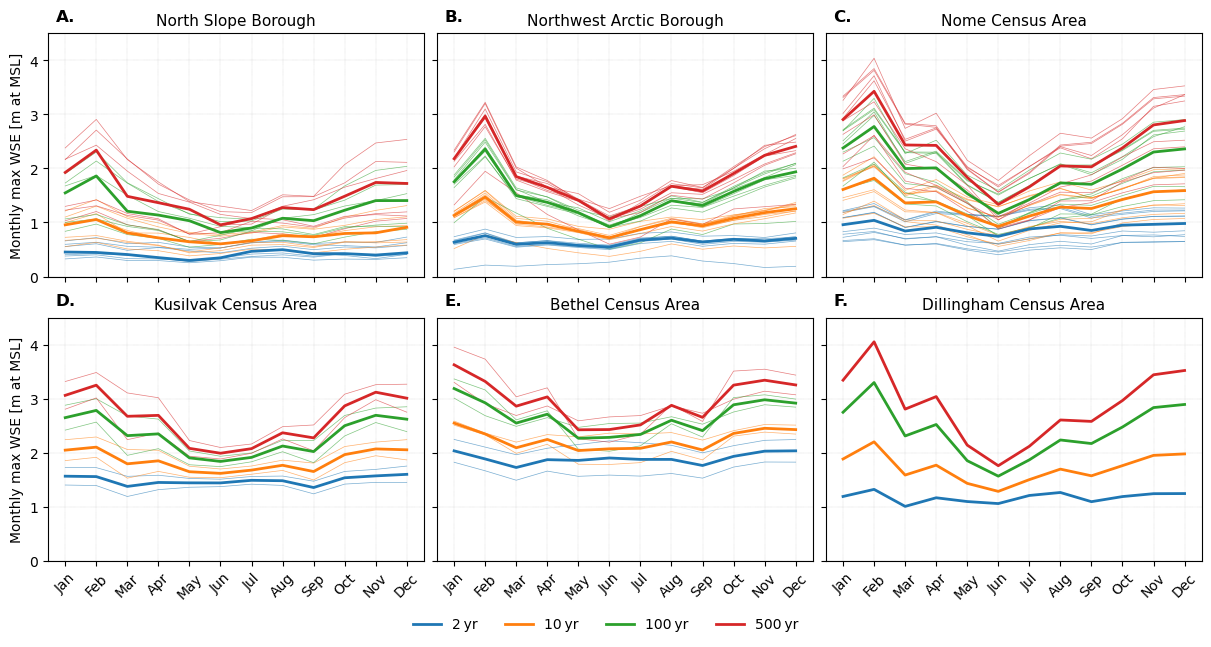

In [23]:
monthly_by_month = {
    comm: {
        m: np.array([monthly_data[comm][yr][m]['zeta_max'] for yr in years])
        for m in range(1, 13)
    }
    for comm in comms_ordered
}

# define return periods and plotting styles
return_periods = [2, 10, 100, 500]
p_levels       = [1/r for r in return_periods]
colors         = ['C0','C1','C2','C3']
months         = np.arange(1, 13)
month_labels   = ['Jan','Feb','Mar','Apr','May','Jun',
                  'Jul','Aug','Sep','Oct','Nov','Dec']
letters = [f"{chr(65 + i)}." for i in range(len(counties))]  # ['A.', 'B.', ...]

# one subplot per county
ncounties = len(counties)
ncols = int(math.ceil(math.sqrt(ncounties)))
nrows = int(math.ceil(ncounties / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.flatten()

# prepare proxy artists for legend
legend_handles = [
    Line2D([0], [0], color=col, lw=2)
    for col in colors
]
legend_labels = [f"{rp} yr" for rp in return_periods]

for idx, (county, info) in enumerate(counties.items()):
    ax = axes[idx]
    comms = info['communities']
    
    # compute and plot each station’s curves
    # collect medians per return period
    median_curves = {rp: [] for rp in return_periods}
    
    for comm in comms:
        for rp, p, col in zip(return_periods, p_levels, colors):
            # compute seasonal values
            q = []
            for m in months:
                vals = monthly_by_month[comm][m]
                vals = vals[~np.isnan(vals)]
                if len(vals) >= 3:
                    params = gumbel_r.fit(vals)
                    q.append(gumbel_r.ppf(1 - p, *params))
                else:
                    q.append(np.nan)
            # plot station line
            ax.plot(months, q, linestyle='-',
                    color=col, linewidth=0.5, alpha=0.6)
            median_curves[rp].append(q)
    
    # overlay median curves with thicker lines
    for rp, col in zip(return_periods, colors):
        arr = np.array(median_curves[rp])
        med = np.nanmedian(arr, axis=0)
        ax.plot(months, med, linestyle='-',
                color=col, linewidth=2.0)
    ax.text(0.02, 1.1, letters[idx],
            transform=ax.transAxes,
            fontsize=12, weight='bold',
            va='top', ha='left', clip_on=False)
    # formatting
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels, rotation=45, fontsize=10)
    ax.set_title(county, fontsize=11)
    if idx % ncols == 0:
        ax.set_ylabel("Monthly max WSE [m at MSL]", fontsize=10)
    ax.grid(True, linestyle=':', linewidth=0.3)
    ax.set_ylim(0, 4.5)
# hide any unused axes
for ax in axes[ncounties:]:
    ax.axis('off')

# shared legend using proxy handles
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='upper center',
    ncol=len(return_periods),
    fontsize=10,
    frameon=False,
    bbox_to_anchor=(0.5, 0.0)
)


plt.savefig(
    '/scratch/tmiesse/project/figures/seasonal_return_county_median.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()

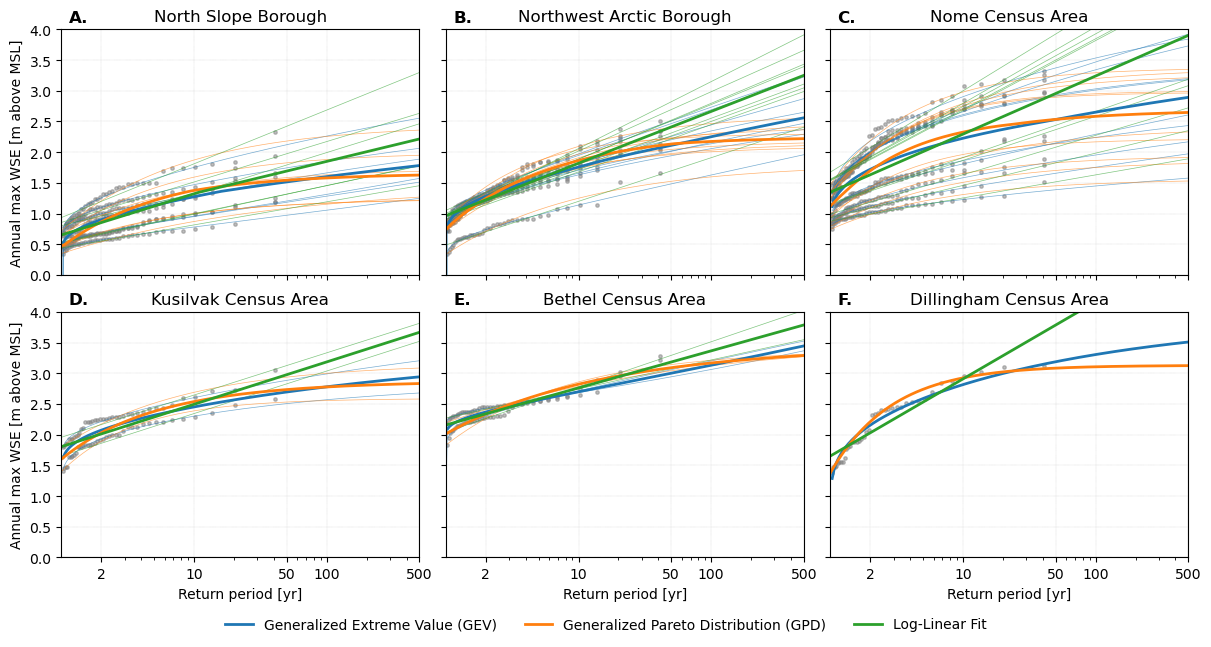

In [37]:
from scipy.stats import genpareto, genextreme

# build per‑station annual max arrays
annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years])
    for comm in comms_ordered
}

# return‑period grid 2–500 yr
T_plot = np.logspace(math.log10(1), math.log10(500), 200)
methods = ['GEV', 'GPD', 'LL']
colors  = {'GEV':'C0', 'GPD':'C1', 'LL':'C2'}

# compute common y‑limit
all_vals = []
for comm in comms_ordered:
    data = annual_max[comm][~np.isnan(annual_max[comm])]
    if data.size < 3: continue
    sorted_vals = np.sort(data)[::-1]
    # GEV
    c, loc, scale = genextreme.fit(sorted_vals)
    all_vals.append(genextreme.ppf(1 - 1/T_plot, c, loc=loc, scale=scale).max())
    # GPD
    thresh = sorted_vals.min()
    excess = sorted_vals - thresh
    c2, loc2, scale2 = genpareto.fit(excess, floc=0)
    all_vals.append((thresh + genpareto.ppf(1 - 1/T_plot, c2, loc=0, scale=scale2)).max())
    # LL
    ranks = np.arange(1, len(sorted_vals)+1)
    T_emp = (len(sorted_vals)+1) / ranks
    a, b = np.polyfit(np.log(T_emp), sorted_vals, 1)
    all_vals.append((a*np.log(T_plot) + b).max())
ymax = max(all_vals) * 1.05

# subplot grid by county
ncounties = len(counties)
ncols = int(math.ceil(math.sqrt(ncounties)))
nrows = int(math.ceil(ncounties / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.flatten()

# legend proxies
legend_handles = [Line2D([0],[0],color=colors[m],lw=2) for m in methods]
legend_labels  = [
    'Generalized Extreme Value (GEV)',
    'Generalized Pareto Distribution (GPD)',
    'Log‑Linear Fit'
]

# ticks
xticks = [2, 10, 50, 100, 500]

for idx, (county, info) in enumerate(counties.items()):
    ax = axes[idx]
    comms = info['communities']
    
    # collect empirical and parametric curves
    empirical = []
    station_curves = {m: [] for m in methods}
    
    for comm in comms:
        data = annual_max[comm]
        valid = ~np.isnan(data)
        vals = data[valid]
        if vals.size < 3:
            continue
        
        sorted_vals = np.sort(vals)[::-1]
        ranks = np.arange(1, len(sorted_vals)+1)
        T_emp = (len(sorted_vals)+1) / ranks
        empirical.append((T_emp, sorted_vals))
        
        # GEV
        c, loc, scale = genextreme.fit(sorted_vals)
        station_curves['GEV'].append(genextreme.ppf(1 - 1/T_plot, c, loc=loc, scale=scale))
        # GPD
        thresh = sorted_vals.min()
        c2, loc2, scale2 = genpareto.fit(sorted_vals - thresh, floc=0)
        station_curves['GPD'].append(thresh + genpareto.ppf(1 - 1/T_plot, c2, loc=0, scale=scale2))
        # Log‑Linear
        a, b = np.polyfit(np.log(T_emp), sorted_vals, 1)
        station_curves['LL'].append(a * np.log(T_plot) + b)
    
    # scatter empirical points (small gray dots)
    for T_emp, sorted_vals in empirical:
        ax.scatter(T_emp, sorted_vals,
                   color='gray', s=6, alpha=0.5)
    
    # plot each station’s parametric curves (thin)
    for method in methods:
        for curve in station_curves[method]:
            ax.plot(T_plot, curve,
                    color=colors[method],
                    linewidth=0.5, alpha=0.6)
    
    # overlay median curves with markers
    for method in methods:
        arr = np.array(station_curves[method])
        median_curve = np.nanmedian(arr, axis=0)
        ax.plot(T_plot, median_curve,
                color=colors[method],
                linewidth=2.0)
                #marker='o', markersize=5, markevery=20)  # markevery to spread markers
    ax.text(0.02, 1.08, letters[idx],
            transform=ax.transAxes,
            fontsize=12, weight='bold',
            va='top', ha='left', clip_on=False)
    # axis formatting
    ax.set_xscale('log')
    ax.set_xlim(1, 500)
    ax.set_ylim(0, 4)
    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    if idx % ncols == 0:
        ax.set_ylabel("Annual max WSE [m above MSL]", fontsize=10)
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Return period [yr]", fontsize=10)
    ax.set_title(county, fontsize=12)
    ax.grid(True, linestyle=':', linewidth=0.3)

# turn off unused axes
for ax in axes[ncounties:]:
    ax.axis('off')

# shared legend
fig.legend(handles=legend_handles,
           labels=legend_labels,
           loc='upper center',
           ncol=3,
           fontsize=10,
           frameon=False,
           bbox_to_anchor=(0.5, 0.0))


plt.savefig(
    '/scratch/tmiesse/project/figures/annual_return_periods_by_county_500yr_scatter.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()

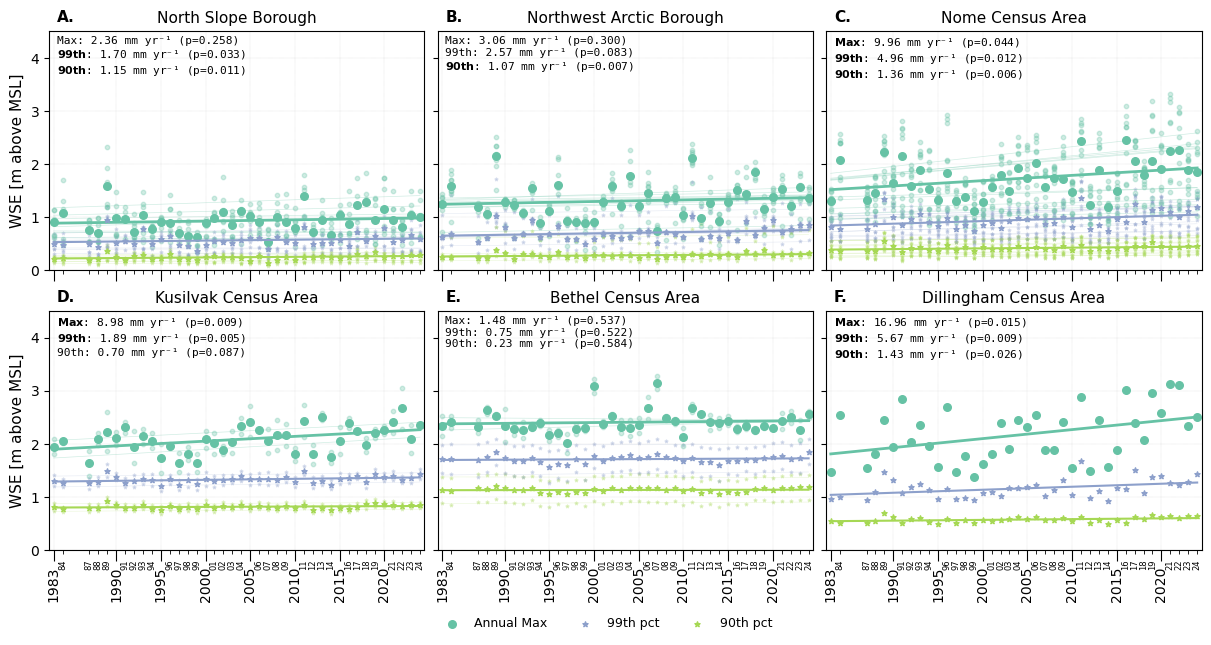

In [54]:
years_int      = np.array([int(y) for y in years])
percentile_keys = ['99th','90th']

# build annual‐max and percentile dicts
annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years])
    for comm in comms_ordered
}
annual_pct = {
    comm: {
        pk: np.array([monthly_data[comm][yr]['zeta_annual_percentiles'][pk] for yr in years])
        for pk in percentile_keys
    }
    for comm in comms_ordered
}

# Set2 colors
cmap       = plt.get_cmap('Set2')
max_color  = cmap(0)
pct_colors = {'99th': cmap(2), '90th': cmap(4)}

metrics = ['max'] + percentile_keys

# subplot grid by county
ncounties = len(counties)
ncols     = int(math.ceil(math.sqrt(ncounties)))
nrows     = int(math.ceil(ncounties / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, sharey=True,
                         constrained_layout=True)
axes = axes.flatten()

for idx, (county, info) in enumerate(counties.items()):
    ax = axes[idx]
    comms = info['communities']

    # 1) station spread: each station’s scatter+trend faintly
    for comm in comms:
        # annual max
        y = annual_max[comm]; v = ~np.isnan(y)
        ax.scatter(years_int[v], y[v], marker='o', s=10,
                   color=max_color, alpha=0.3, zorder=1)
        if v.sum() >= 2:
            m, b = np.polyfit(years_int[v], y[v], 1)
            ax.plot(years_int, b + m*years_int,
                    color=max_color, linewidth=0.5, alpha=0.3, zorder=1)
        # percentiles
        for pk in percentile_keys:
            ypk = annual_pct[comm][pk]; vp = ~np.isnan(ypk)
            ax.scatter(years_int[vp], ypk[vp], marker='*', s=5,
                       color=pct_colors[pk], alpha=0.3, zorder=1)
            if vp.sum() >= 2:
                m_p, b_p = np.polyfit(years_int[vp], ypk[vp], 1)
                ax.plot(years_int, b_p + m_p*years_int,
                        color=pct_colors[pk], linewidth=0.3, alpha=0.3, zorder=1)

    # 2) county‐median: scatter, trend, and annotation
    lines = []
    for m in metrics:
        # assemble data
        if m == 'max':
            arr, color, marker, s_med, lw = (
                np.vstack([annual_max[c] for c in comms]),
                max_color, 'o', 30, 2
            )
            label = 'Annual Max'
            name = 'Max'
        else:
            arr, color, marker, s_med, lw = (
                np.vstack([annual_pct[c][m] for c in comms]),
                pct_colors[m], '*', 15, 1.5
            )
            label = f'{m} pct'
            name = m

        med = np.nanmedian(arr, axis=0)
        vm  = ~np.isnan(med)

        # scatter
        ax.scatter(years_int[vm], med[vm],
                   marker=marker, s=s_med,
                   color=color, alpha=1, zorder=2,
                   label=label if idx==0 else None)
        # trend line
        if vm.sum() >= 2:
            slope, intercept = np.polyfit(years_int[vm], med[vm], 1)
            ax.plot(years_int, intercept + slope*years_int,
                    color=color, linewidth=lw, alpha=1, zorder=2)
            # Mann–Kendall
            res = mk.original_test(med[vm])
            p = res.p
            # bold name if significant
            lab = rf"$\mathbf{{{name}}}$" if p < 0.05 else name
            lines.append(f"{lab}: {slope*1000:.2f} mm yr⁻¹ (p={p:.3f})")

    # annotation block
    text = "\n".join(lines)
    ax.text(0.02, 0.98, text,
            transform=ax.transAxes,
            family='monospace', size=8,
            va='top', clip_on=False)

    # formatting
    ax.set_title(county, fontsize=11)
    ax.set_xlim(years_int.min()-0.5, years_int.max()+0.5)
    majors = years_int[::5]; minors = years_int
    ax.xaxis.set_major_locator(FixedLocator(majors))
    ax.xaxis.set_minor_locator(FixedLocator(minors))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f"{int(x)%100:02d}"))
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=10, length=8)
    ax.tick_params(axis='x', which='minor', rotation=90, labelsize=6, length=3)
    ax.set_ylim(0, 4.5)
    ax.grid(True, linestyle=':', linewidth=0.25)
    if idx % ncols == 0:
        ax.set_ylabel("WSE [m above MSL]", fontsize=11)
    else:
        ax.tick_params(labelleft=False)

    # subplot letter
    ax.text(0.02, 1.04, letters[idx],
            transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)

# hide unused panels
for ax in axes[ncounties:]:
    ax.axis('off')

# shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center', ncol=len(metrics),
           frameon=False, fontsize=9,
           bbox_to_anchor=(0.5, 0.0))


plt.savefig(
    '/scratch/tmiesse/project/figures/county_median_annual_trends_spread.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()